C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


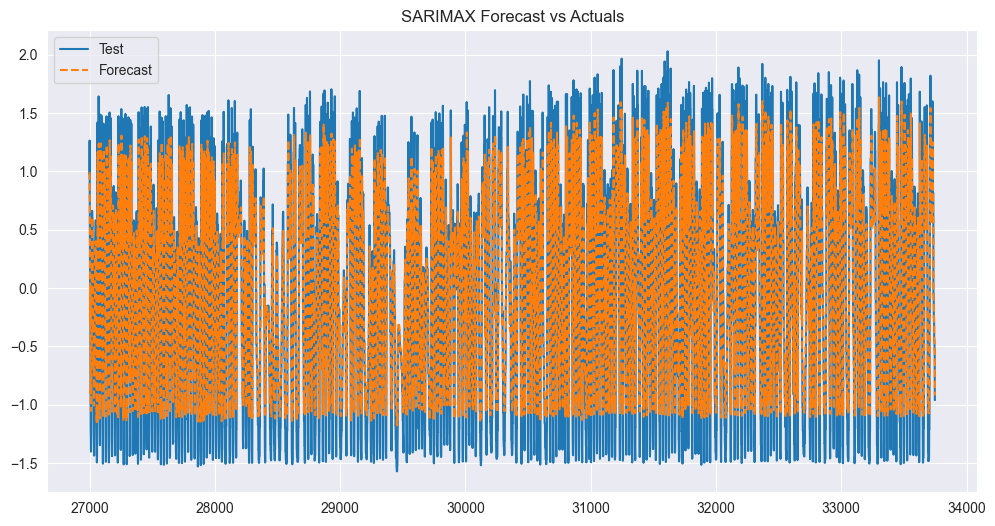

In [4]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
df_raw = pd.read_csv('Train.csv')

# Convert to datetime format and extract hour
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw['hour'] = df_raw['date_time'].dt.hour

# Set 'date_time' as the index
df_raw.set_index('date_time', inplace=True)

# One-hot encode categorical columns
df_is_holiday = pd.get_dummies(df_raw['is_holiday'])
df_weather_type = pd.get_dummies(df_raw['weather_type'])
df_weather_description = pd.get_dummies(df_raw['weather_description'])

# Concatenate one-hot encoded columns and original dataframe
df_processed = pd.concat([df_raw, df_is_holiday, df_weather_type, df_weather_description], axis=1)

# Drop original non-numeric columns
df_processed.drop(columns=['is_holiday', 'weather_type', 'weather_description'], inplace=True)

# Feature selection and scaling
selected_features = ['traffic_volume', 'hour', 'temperature', 'clouds_all', 'humidity']
df_selected = df_processed[selected_features]

scaler = StandardScaler()
df_processed_scaled = scaler.fit_transform(df_selected)

# Prepare data for SARIMAX
n_past = 14  # Number of past data we want to use to predict the future.
n_future = 1  # Number of data we want to look into the future based on the past data.

# Here, we'll use the entire scaled data as our exogenous variables
exog_data = df_processed_scaled[:-n_future, :-1]
endog_data = df_processed_scaled[n_future:, 0]

# Split data
split_ratio = 0.8
split_point = int(len(endog_data) * split_ratio)
train_endog = endog_data[:split_point]
train_exog = exog_data[:split_point]
test_endog = endog_data[split_point:]
test_exog = exog_data[split_point:]

# SARIMAX Model
model = SARIMAX(train_endog, exog=train_exog, order=(2,1,2), seasonal_order=(2,0,2,12))
results = model.fit(disp=True)

# Forecasting
forecast = results.predict(start=len(train_endog), end=len(train_endog)+len(test_endog)-1, exog=test_exog)

# Visualization
plt.figure(figsize=(12, 6))
#plt.plot(range(len(train_endog)), train_endog, label='Train')
plt.plot(range(len(train_endog), len(endog_data)), test_endog, label='Test')
plt.plot(range(len(train_endog), len(endog_data)), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('SARIMAX Forecast vs Actuals')
plt.show()

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_endog, forecast))

# Compute MAE
mae = mean_absolute_error(test_endog, forecast)

# Compute MAPE
mape = np.mean(np.abs((test_endog - forecast) / test_endog)) * 100

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Root Mean Squared Error (RMSE): 0.3816718704908097
Mean Absolute Error (MAE): 0.29637894536688747
Mean Absolute Percentage Error (MAPE): 91.9228585011329%


In [5]:
# Assuming the test set is hourly data and we want to visualize the last 7 days
hours_per_day = 24
days_to_visualize = 7
observations_to_visualize = hours_per_day * days_to_visualize

# Adjust the visualization range
visualization_start = len(train_endog) + len(test_endog) - observations_to_visualize
visualization_end = len(train_endog) + len(test_endog)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(visualization_start, visualization_end), test_endog[-observations_to_visualize:], label='Actual Test')
plt.plot(range(visualization_start, visualization_end), forecast_values[-observations_to_visualize:], label='Forecast', linestyle='--')
plt.legend()
plt.title(f'SARIMAX Forecast vs Actuals for the Last {days_to_visualize} Days')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.xticks(range(visualization_start, visualization_end, hours_per_day), rotation=45)  # Show one tick per day for clarity
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()